# Final model for Dog Breed Identification challenge


### Authors: Tarap, Noll


This Notebook contains the final model submitted for the Kaggle Dog Breed Identification challenge (https://www.kaggle.com/c/dog-breed-identification/leaderboard).



## Setting up the environment

In [30]:
from keras import applications
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression


import pandas as pd
import scipy.misc
import numpy as np
import shutil
import os
import math
import matplotlib.pyplot as plt

### Creating the folder structure

In order to use the Keras package flow_from_directory, the training and validation folders were set up to contain one sub-directory per image class. This helps to streamline the model building pipeline and offers some speed improvement over iterating each image.

The final folder structure is as follows:


* data/
    * train/
        * affenpinscher/
            * dog001.jpg
            * dog002.jpg
            * ...
        * afghan_hound/
            * dog011.jpg
            * dog012.jpg
            * ...
    * validation/
        * affenpinscher/
            * dog001.jpg
            * dog002.jpg
            * ...
        * afghan_hound/
            * dog011.jpg
            * ** dog012.jpg
            ** ...
    * test/
        * dog991.jpg
        * dog992.jpg
        * ...
        

In [31]:
# Read labels
labels = pd.read_csv("data/labels.csv")
data_dir = '/home/ubuntu/notebooks/data/'

train_data_dir =  data_dir + '/train'
validation_data_dir = data_dir + '/validation'

# Create 90/10 split of train to validation
np.random.seed(1234)
np.random.random(len(labels))

idx = np.random.random(len(labels))<.9

train_labels = labels["breed"][idx]
validation_labels = labels["breed"][~idx]

num_classes = len(set(labels))

In [32]:

#One off operation. Move these to the validation folder
validation_ids = labels["id"][~idx]
validation_files = ["%s.jpg" % s for s in validation_ids]

def populate_validation():
    for f in os.listdir(data_dir + 'train'):
        if f in validation_files:
            shutil.move(data_di + 'train/' + f , data_di + 'validation')

#populate_validation()

In [33]:
# For each unique class in labels, create a corresponding folder for training and validation

def create_subfolders(data=labels, folder='train'):
    for index, row in data.iterrows():
        tf = data_dir + "/" + folder + "/" + row["breed"]
        if not os.path.isdir(tf):
            #create empty folders
            os.makedirs(tf)

    
#create_subfolders(folder='train')        
#create_subfolders(folder='validation') 

In [34]:
# Populate the respective class folders in training and validation 

def populate_subfolders(data=labels, folder='train'):    
    for f in os.listdir(data_dir + "/" + folder ):
        fn = f.split('.')[0]
        try:
            breed = data[data.id == fn]["breed"].values[0]
            shutil.move("%s%s/%s" % (data_dir, folder, f), "%s%s/%s" % (data_dir, folder, breed))
        except IndexError:
            print ("problem: " + data[data.id == fn]["breed"])
            

#populate_subfolders(folder='train')  
#populate_subfolders(folder='validation')  

## Model and hyper parameter selection

### Parameter Selections

Image width and height of 224 was selected as we tried our model with Inception_v3 and Xception and these were standard input sizes taken by both models.



In [35]:

# dimensions of our images.
img_width, img_height = 224, 224
epochs = 15
batch_size = 16


### The Model

Following our attempts to code the Model from scratch, we found a large improvement to our model using transfer learning.

We used the Inception V3 architecture, pre-trained on the ImageNet dataset. We found that this was already better than our previous model and Inception provided slightly better logloss than Xception.

We opted for a simple model with two fully connected layers and a dropout of .5. We found .5 to be a good balance between over and underfitting of the model. 


In [36]:

def create_model(input_shape,num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

For the purpose of modularization and flexibility, we have split the as follows:
    - Apply and save bottleneck features from train and validation
    - Train our model against our holdout validation set
    - Predict and submit using best performing model
    

In [37]:
# Saving the inception bottleneck features

def save_bottlebeck_features():
    
    #Normalise Images
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
    train_datagen = ImageDataGenerator(rescale=1. / 255)    
    
    # Retrieve weights from InceptionV3 trained on imagenet
    model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_train_samples = len(train_generator.filenames)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    # Apply top layer model to training images
    bottleneck_features_train = model.predict_generator(
        train_generator, predict_size_train) 
    
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    # Repeat above for the validation images
    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(validation_generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        validation_generator, predict_size_validation)    
    
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

save_bottlebeck_features()


Found 9148 images belonging to 120 classes.
Found 1074 images belonging to 120 classes.


After trying the following image augmentation, we found that the model actually did worse than without it so this was left off the final model.



In [38]:

def train_model():
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator_train = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_train.filenames)
    num_classes = len(generator_train.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_train.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_train.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    # Repeat above for validation
    generator_validation = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_validation.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_validation.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)
    
    # Add fully connected layers
    model = create_model(train_data.shape[1:],num_classes)
   
    
    model.compile(optimizer="sgd",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', 
                               verbose=1, save_best_only=True)
    
    history = model.fit(train_data, train_labels,
                        epochs=12,
                        batch_size=batch_size,
                        callbacks=[checkpointer],
                        validation_data=(validation_data, validation_labels))
    return history

Found 9148 images belonging to 120 classes.
Found 1074 images belonging to 120 classes.
Train on 9148 samples, validate on 1074 samples
Epoch 1/12
9148/9148 [==============================] - 9s 961us/step - loss: 2.9703 - acc: 0.3496 - val_loss: 1.2907 - val_acc: 0.6806
Epoch 2/12
9148/9148 [==============================] - 7s 790us/step - loss: 1.6261 - acc: 0.5951 - val_loss: 1.1272 - val_acc: 0.7291
Epoch 3/12
9148/9148 [==============================] - 7s 719us/step - loss: 1.2976 - acc: 0.6670 - val_loss: 1.1465 - val_acc: 0.7179
Epoch 4/12
9148/9148 [==============================] - 7s 719us/step - loss: 1.0864 - acc: 0.7137 - val_loss: 1.1400 - val_acc: 0.7328
Epoch 5/12
9148/9148 [==============================] - 7s 718us/step - loss: 0.9090 - acc: 0.7543 - val_loss: 1.1558 - val_acc: 0.7346
Epoch 6/12
9148/9148 [==============================] - 7s 717us/step - loss: 0.8173 - acc: 0.7688 - val_loss: 1.1563 - val_acc: 0.7318
Epoch 7/12
9148/9148 [==========================

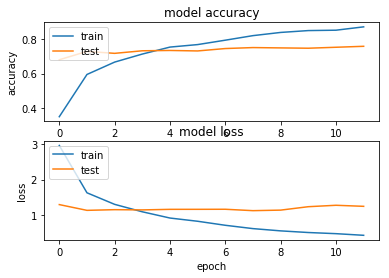

In [39]:
hist = train_model()


plt.figure(1)

#plot accuracy
plt.subplot(211)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#plot loss
plt.subplot(212)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


As we can see above, the model starts overfitting very quickly. This is probably due to SGD being greedy. When using Adam we see the opposite, extremely slow convergence. Regardless, this was the best model that was acheived.

### Submission Code

Prepare and submit predictions

In [41]:

def get_predictions():
    to_submit = pd.read_csv("./data/sample_submission.csv")
    predictions = {}
    class_dictionary = np.load('class_indices.npy').item()
    num_classes = len(class_dictionary)
    incv3 = inception_v3.InceptionV3(weights='imagenet', include_top=False)
    
    model = create_model((5, 5, 2048),num_classes)
    model.load_weights('bestmodel.hdf5')
    
    for image_id in to_submit['id']:
        # Get images
        image_path = os.path.join("data/", "test", image_id + ".jpg") 
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)
     
        image = image / 255
        image = np.expand_dims(image, axis=0)
        bottleneck_prediction = incv3.predict(image)
        #print("predicting: " + image_id)
        predictions[image_id] = model.predict_proba(bottleneck_prediction)
    return predictions

preds = get_predictions()

    

1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


In [42]:

npred = {}
for key,val in preds.items():
    npred[key] = val.tolist()[0]

preddf = pd.DataFrame.from_dict(npred,orient='index')
preddf.columns = np.load('class_indices.npy').item()
preddf.insert(0, 'id',  preddf.index)
preddf.head()
preddf.to_csv("submission.csv", index=False)
